In [5]:
import sys
#sys.path.append('/usr/local/lib/python3.9/site-packages') 
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import cvxopt as cvxopt
from shapely.geometry import Polygon, Point
#import shapely.affinity as affinity
import random
import math

In [1]:
%load_ext blackcellmagic

In [6]:
# TF packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras import backend as K

In [245]:
import matplotlib as mpl
import matplotlib.patches as mpatches
plt.rcParams['text.usetex'] = False
mpl.style.use('seaborn')

#### Functions

In [2]:
def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P = 0.5 * (P + P.T)  # make sure P is symmetric
    args = [cvxopt.matrix(P), cvxopt.matrix(q)]
    if G is not None:
        args.extend([cvxopt.matrix(G), cvxopt.matrix(h)])
        if A is not None:
            args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
    cvxopt.solvers.options["show_progress"] = False
    cvxopt.solvers.options["maxiters"] = 100
    sol = cvxopt.solvers.qp(*args)
    if "optimal" not in sol["status"]:
        return None
    return np.array(sol["x"]).reshape((P.shape[1],))


def calc_distance_and_angle(x0, xg):
    dx = xg - x0
    d = math.hypot(dx[0], dx[1])
    theta = math.atan2(dx[1], dx[0])
    return d, theta


def interval_sample(min_x, max_x, res=1):
    return (((max_x) - (min_x)) / res) * np.random.randint(0, res) + (min_x)


def angular_diff(x, y):  # angular difference
    d = y - x
    return math.atan2(math.sin(d), math.cos(d))


def zero_2pi_adj(theta):
    if theta > 2 * np.pi:
        temp = theta / (2 * np.pi) - 1
        k = math.ceil(temp)
        theta = theta - k * 2 * np.pi
    elif theta < 0:
        temp = -theta / (2 * np.pi)
        k = math.ceil(temp)
        theta = theta + k * 2 * np.pi
    return theta


def pi_pi_adj(theta):
    if theta > np.pi:
        temp = theta / (2 * np.pi) - 0.5
        k = math.ceil(temp)
        theta = theta - k * 2 * np.pi
    elif theta < -np.pi:
        temp = -theta / (2 * np.pi) - 0.5
        k = math.ceil(temp)
        theta = theta + k * 2 * np.pi
    return theta


def calc_angle(from_x, to_x):
    dx = to_x[0:2] - from_x[0:2]
    d = math.hypot(dx[0], dx[1])
    theta = math.atan2(dx[1], dx[0])
    return zero_2pi_adj(theta)


def OPT(V, LfV, LgV, x0, xg, gamma=0, v_gain=1.2, w_gain=1):
    # robot spec
    v_max = 1.0
    v_min = 0.0
    w_max = 0.5
    w_min = -0.5

    # generate input sample
    dist_goal, theta_goal = calc_distance_and_angle(x0, xg)
    u_ref = np.array([0, 0], "f")
    u_ref[0] = np.exp(-v_gain / dist_goal) * v_max
    u_ref[1] = w_gain * angular_diff(x0[2], theta_goal)

    # OPT formulate: min 0.5*u'Hu s.t. Nu<=m
    A = np.zeros((6, 3))
    b = np.zeros((6, 1))

    ## lyapanov
    A[0, 0:2] = LgV(x0)
    A[0, 2] = -1
    b[0] = -LfV(x0)
    # slack variabl of lyapanov
    A[1, 2] = -1

    ## Control constraints
    A[2, 0] = 1.0
    b[2] = v_max
    A[3, 0] = -1.0
    b[3] = -v_min
    A[4, 1] = 1.0
    b[4] = w_max
    A[5, 1] = -1.0
    b[5] = -w_min

    H = np.zeros((3, 3))
    ff = np.zeros((3, 1))
    H[0, 0] = 10
    H[1, 1] = 10
    H[2, 2] = 0
    ff[0] = -10 * u_ref[0]
    ff[1] = -10 * u_ref[1]
    ff[2] = 6
    uq = cvxopt_solve_qp(H, ff, A, b)

    return uq[0:2]


def traj_gen(
    x0, x0_NN, xg, V, LfV, LgV, controller, iteration=40, mode="NN"
):  # modes: 'NN' and 'OPT'
    traj_x = []
    traj_x_NN = []
    traj_u = []

    traj_x.append(x0)
    traj_x_NN.append(x0_NN)

    if mode == "NN":
        for j in range(iteration):
            u = controller.predict(np.array([x0_NN])).flatten()
            x_dot = (Real_x_r(x0, u[0:2])).flatten()
            x0 = (T * Real_x_r(x0, u[0:2])).flatten() + x0
            x0[2] = pi_pi_adj(x0[2])
            x0_NN = reg_2_NN_coord(x0)

            traj_u.append(u)
            traj_x.append(x0)
            traj_x_NN.append(x0_NN)

        traj_u.append(u)

        traj_x = np.array(traj_x)
        traj_x_NN = np.array(traj_x_NN)
        traj_u = np.array(traj_u)
    else:
        while (np.linalg.norm(x0[0:2] - xg[0:2])) > xg[2]:
            u = controller(V, LfV, LgV, x0, xg)
            x_dot = (Real_x_r(x0, u)).flatten()
            x0 = (T * Real_x_r(x0, u)).flatten() + x0
            x0[2] = pi_pi_adj(x0[2])
            x0_NN = reg_2_NN_coord(x0)

            traj_u.append(u)
            traj_x.append(x0)
            traj_x_NN.append(x0_NN)

        traj_u.append(u)

        traj_x = np.array(traj_x)
        traj_x_NN = np.array(traj_x_NN)
        traj_u = np.array(traj_u)

        temp = np.array([np.linspace(0.0, 1.0, num=traj_u.shape[0])])
        traj_u = np.concatenate((traj_u, temp.T), axis=1)

    return traj_x, traj_x_NN, traj_u


def reg_2_NN_coord(x):
    x_NN = np.zeros((4))
    x_NN[0] = x[0]
    x_NN[1] = x[1]
    x_NN[2] = math.sin(x[2])
    x_NN[3] = math.cos(x[2])

    return x_NN


def sample_generate(x_interval):
    x = np.zeros((3))
    x[0] = interval_sample(x_interval[0][0], x_interval[0][1], 300)
    x[1] = interval_sample(x_interval[1][0], x_interval[1][1], 300)
    x[2] = interval_sample(x_interval[2][0], x_interval[2][1], 6)

    x_NN = reg_2_NN_coord(x)
    return x, x_NN

In [3]:
class controller:
    def __init__(self, alpha1=1, alpha2=1):

        # parameters
        l = 0.0
        r = 0.2
        self.alpha1 = alpha1
        self.alpha2 = alpha2

        # robot spec
        self.v_max = 1.0
        self.v_min = 0.0
        self.w_max = 0.5
        self.w_min = -0.5

        # Symbolize the control
        xr1, xr2, xr3, theta_g, theta_o = symbols("xr1 xr2 xr3 theta_g theta_o")
        xo1, xo2, xo3, xg1, xg2, xg3 = symbols("xo1 xo2 xo3 xg1 xg2 xg3")
        u1, u2 = symbols("u1,u2")

        # Vector of states and inputs + g and f:
        x_r_s = Matrix([xr1, xr2, xr3])  # robot state [x,y,theta]
        x_o_s = Matrix([xo1, xo2, xo3])  # obstacle [x,y,r]
        x_g_s = Matrix([xg1, xg2, xg3])  # goal [x,y,r]
        u_s = Matrix([u1, u2])  # control [v,w]
        f = Matrix([0.0, 0.0, 0.0])
        g = Matrix(
            [
                [cos(x_r_s[2]), -l * sin(x_r_s[2])],
                [sin(x_r_s[2]), l * cos(x_r_s[2])],
                [0.0, 1.0],
            ]
        )

        # create constraints

        # goal Lyp1
        V1 = (x_r_s[0] - x_g_s[0]) ** 2 + (x_r_s[1] - x_g_s[1]) ** 2 - (l) ** 2
        V1_d = V1.diff(Matrix([x_r_s]))
        self.V1 = lambdify([x_r_s, x_g_s], V1)
        self.LfV1 = lambdify([x_r_s, x_g_s], V1_d.T * f)
        self.LgV1 = lambdify([x_r_s, x_g_s], V1_d.T * g)

        # goal Lyp2
        V2 = (theta_g - x_r_s[2]) ** 2
        V2_d = V2.diff(Matrix([x_r_s]))
        self.V2 = lambdify([x_r_s, x_g_s, theta_g], V2)
        self.LfV2 = lambdify([x_r_s, x_g_s, theta_g], V2_d.T * f)
        self.LgV2 = lambdify([x_r_s, x_g_s, theta_g], V2_d.T * g)

        # obstacle CBF1
        CBF1 = (
            (x_r_s[0] - x_o_s[0]) ** 2
            + (x_r_s[1] - x_o_s[1]) ** 2
            - (r + x_o_s[2] + l) ** 2
        )
        CBF1_d = CBF1.diff(Matrix([x_r_s]))
        self.h1 = lambdify([x_r_s, x_o_s], CBF1)
        self.Lfh1 = lambdify([x_r_s, x_o_s], CBF1_d.T * f)
        self.Lgh1 = lambdify([x_r_s, x_o_s], CBF1_d.T * g)

        # obstacle CBF2
        CBF2 = (theta_o - x_r_s[2]) ** 2 - (
            r
            + l
            + asin(
                x_o_s[2] / sqrt((x_r_s[0] - x_o_s[0]) ** 2 + (x_r_s[1] - x_o_s[1]) ** 2)
            )
        ) ** 2  # >\pi/2
        CBF2_d = CBF2.diff(Matrix([x_r_s]))
        self.h2 = lambdify([x_r_s, x_o_s, theta_o], CBF2)
        self.Lfh2 = lambdify([x_r_s, x_o_s, theta_o], CBF2_d.T * f)
        self.Lgh2 = lambdify([x_r_s, x_o_s, theta_o], CBF2_d.T * g)

    def OPT(self, x0, x0_nn, u_ref, xo, xg):

        # initialize constraints
        A = np.zeros((2 + 4 * xo.shape[0] + 4, 2 + 1 + 2 * xo.shape[0]))
        b = np.zeros((2 + 4 * xo.shape[0] + 4, 1))
        #         A = np.zeros((10,5))
        #         b = np.zeros((10,1))

        # lyapanovs: LgV * u - b_lyp <= - LfV - LgV * u_ref
        ## Lyp1
        A[0, 0:2] = self.LgV1(x0, xg)
        A[0, 2] = -1
        b[0] = -self.LfV1(x0, xg) - np.matmul(self.LgV1(x0, xg), u_ref.T[0:2, 0])
        ## slack1
        A[1, 2] = -1

        # control barrier functions: - Lgh * u - b_cbf <= alpha * h + Lfh + Lgh * u_ref
        for i in range(xo.shape[0]):
            ## CBF1
            A[4 * i + 2, 0:2] = -self.Lgh1(x0, xo[i, :])
            A[4 * i + 2, 2 * i + 3] = -1
            b[4 * i + 2] = (
                self.alpha1 * self.h1(x0, xo[i, :])
                + self.Lfh1(x0, xo[i, :])
                + np.matmul(self.Lgh1(x0, xo[i, :]), u_ref.T[0:2, 0])
            )
            ## slack2
            A[4 * i + 3, 2 * i + 3] = -1

            ## CBF2
            t_o = calc_angle(x0, xo[i, :])
            A[4 * i + 4, 0:2] = -self.Lgh2(x0, xo[i, :], t_o)
            A[4 * i + 4, 2 * i + 4] = -1
            b[4 * i + 4] = (
                self.alpha2 * self.h2(x0, xo[i, :], t_o)
                + self.Lfh2(x0, xo[i, :], t_o)
                + np.matmul(self.Lgh2(x0, xo[i, :], t_o), u_ref.T[0:2, 0])
            )
            ## slack3
            A[4 * i + 5, 2 * i + 4] = -1

        #         ## CBF1
        #         A[2, 0:2] = -self.Lgh1(x0)
        #         A[2,3] = -1
        #         b[2] = self.alpha1*self.h1(x0) + self.Lfh1(x0) + np.matmul(self.Lgh1(x0), u_ref.T[0:2,0])
        #         ## slack3
        #         A[3,3] = -1

        #         ## CBF2
        #         t_o = calc_angle(x0,self.xo)
        #         A[4, 0:2] = -self.Lgh2(x0, t_o)
        #         A[4,4] = -1
        #         b[4] = self.alpha2*self.h2(x0, t_o) + self.Lfh2(x0, t_o) + np.matmul(self.Lgh2(x0, t_o), u_ref.T[0:2,0])
        #         ## slack4
        #         A[5,4] = -1

        # constraint on control
        A[4 * i + 6, 0] = 1.0
        b[4 * i + 6] = self.v_max - u_ref.flatten()[0]
        A[4 * i + 7, 0] = -1.0
        b[4 * i + 7] = u_ref.flatten()[0] - self.v_min
        A[4 * i + 8, 1] = 1.0
        b[4 * i + 8] = self.w_max - u_ref.flatten()[1]
        A[4 * i + 9, 1] = -1.0
        b[4 * i + 9] = u_ref.flatten()[1] - self.w_min

        # cost
        H = np.zeros((2 + 1 + 2 * xo.shape[0], 2 + 1 + 2 * xo.shape[0]))
        ff = 5 * np.ones((2 + 1 + 2 * xo.shape[0], 1))
        H[0, 0] = 2
        H[1, 1] = 2

        ff[0] = 0
        ff[1] = 0
        ff[2] = 2
        #         ff[3] = 10
        #         ff[4] = 10

        # solve
        try:
            uq = cvxopt_solve_qp(H, ff, A, b)
        except:
            print("H: {}".format(H))
            print("ff: {}".format(ff))
            print("A: {}".format(A))
            print("b: {}".format(b))
            print("x0: {}".format(x0))
            print("t_g: {}".format(t_g))
        if uq is None:
            uq = np.zeros([0, 0, 0, 0, 0])
        return uq, A, b

#### Bicycle model

In [213]:
# symbolize the control
xr1,xr2,xr3,theta_g = symbols('xr1 xr2 xr3 theta_g')  
u1,u2 = symbols('u1,u2')

# Vector of states and inputs + g and f:
x_r_s = Matrix([xr1,xr2,xr3]) #robot state [x,y,theta]
u_s = Matrix([u1,u2])         #control [v,w]
Real_x_r = lambdify([x_r_s, u_s], Matrix([[cos(x_r_s[2]), 0.], [sin(x_r_s[2]), 0.], [0., 1.]])*u_s, 'numpy') #???

#### Real-time safety-guided policy repair

In [374]:
T = 0.5
xg = np.array([0,0,0.3])
xo = np.array([np.array([-2,-2,0.2]), np.array([-1,-3,0.2]), np.array([0.5,-1,0.2]), np.array([-1,-1,0.2]), np.array([-3,-1,0.2]), np.array([-2,-.5,0.2])])
x0_interval = [(-5,-3),(-5,-3),(0,np.pi/2)]

control = controller()
x0, x0_nn = sample_generate(x0_interval)

# load reference controller 
ref_control = keras.models.load_model('model_3_out/my_model',compile=False)

traj = []
traj_nn = []
cont = []
cont_err = []
traj.append(x0)
traj_nn.append(x0_nn)

while np.linalg.norm(x0[0:2]-xg[0:2])>xg[2]+0.05:
    u_ref = ref_control.predict(np.array([x0_nn]))
    delta_u, A, b = control.OPT(x0, x0_nn, u_ref, xo, xg)
    u = u_ref.flatten()[0:2] + delta_u[0:2]
    
    x0 = (T * Real_x_r(x0, u)).flatten() + x0
    x0[2] = pi_pi_adj(x0[2])
    x0_nn = reg_2_NN_coord(x0)
    
    cont_err.append(delta_u[0:2])
    cont.append(u)
    traj.append(x0)
    traj_nn.append(x0_nn)
    
cont.append(u)
cont_err.append(delta_u[0:2])

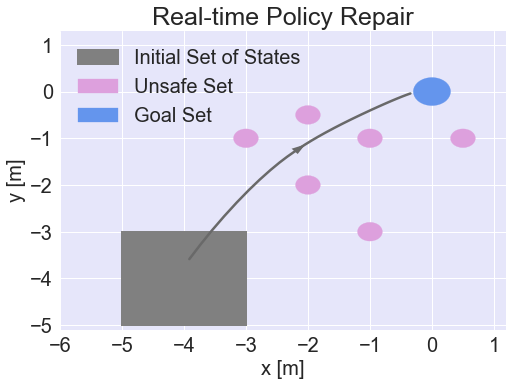

In [375]:
traj = np.stack(traj,0)
traj_nn = np.stack(traj_nn,0)
cont = np.stack(cont,0)
cont_err = np.stack(cont_err,0)

left, bottom, width, height = (x0_interval[0][0], x0_interval[1][0], 2, 2)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=True,
                        color="grey",
                       linewidth=2, label = "Initial Set of States")
                       #facecolor="red")


plt.plot(np.array(traj)[:,0],np.array(traj)[:,1], linewidth=2.5, color= 'dimgray')
plt.arrow(np.array(traj)[10,0], np.array(traj)[10,1], np.array(traj)[11,0]-np.array(traj)[10,0], np.array(traj)[11,1]-np.array(traj)[10,1], shape='full', color= 'dimgray', lw=0, length_includes_head=True, head_width=0.15)


plt.xlabel('x [m]',fontsize=20)
plt.ylabel('y [m]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((-6,1.2))
plt.ylim((-5.1,1.3))
plt.title(r'Real-time Policy Repair',fontsize=25)
ax = plt.gca()
ax.add_patch(rect)
ax.set_facecolor("lavender")
for k in range(xo.shape[0]-1):
    ax.add_patch(plt.Circle((xo[k, 0], xo[k, 1]), xo[k, 2], color='plum', fill=True))
ax.add_patch(plt.Circle((xo[-1, 0], xo[-1, 1]), xo[-1, 2], color='plum', fill=True, label="Unsafe Set")) 
ax.add_patch(plt.Circle((xg[0], xg[1]), xg[2], color='cornflowerblue', fill=True, label="Goal Set"))
#ax.add_patch(plt.Circle((xo[0], xo[1]), xo[2], color='plum', fill=True, label="Unsafe Set"))
# ax.quiver(np.concatenate(traj_rep1)[:,0],np.concatenate(traj_rep1)[:,1],np.concatenate(traj_rep_dot1)[:,0],np.concatenate(traj_rep_dot1)[:,1],color = "darkgray")
ax.legend(loc="upper left",fontsize=20,frameon=False)
plt.savefig('real_time_single_traj.eps', format='eps')

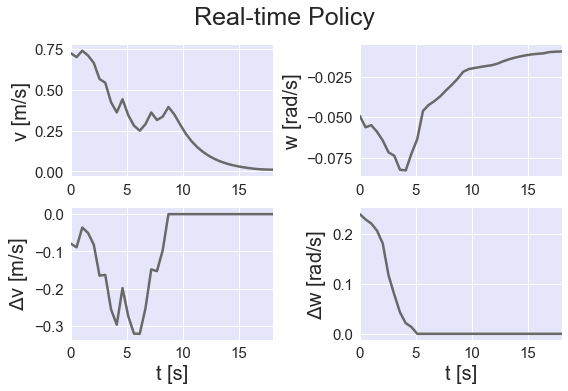

In [376]:
t = np.linspace(0,T*cont.shape[0],cont.shape[0], endpoint = True)

fig, axs = plt.subplots(2,2)
fig.suptitle(r'Real-time Policy',fontsize=25)
axs[0,0].plot(t, cont[:,0], linewidth=2.5, color= 'dimgray')
axs[0, 0].set_ylabel('v [m/s]',fontsize=20)
axs[1,0].plot(t, cont_err[:,0], linewidth=2.5, color= 'dimgray')
axs[1, 0].set_ylabel('$\Delta$v [m/s]',fontsize=20)
axs[0,1].plot(t, cont[:,1], linewidth=2.5, color= 'dimgray')
axs[0, 1].set_ylabel('w [rad/s]',fontsize=20)
axs[1,1].plot(t, cont_err[:,1], linewidth=2.5, color= 'dimgray')
axs[1, 1].set_ylabel('$\Delta$w [rad/s]',fontsize=20)
# axs[0,0].set_xticklabels([0,4,5], fontsize=12)
axs[0,0].tick_params(axis="both", labelsize=15) 
axs[0,1].tick_params(axis="both", labelsize=15) 
axs[1,0].tick_params(axis="both", labelsize=15) 
axs[1,1].tick_params(axis="both", labelsize=15) 
axs[0,0].set_facecolor("lavender")
axs[0,1].set_facecolor("lavender")
axs[1,0].set_facecolor("lavender")
axs[1,1].set_facecolor("lavender")
axs[0,0].set_xlim([0, 18])
axs[0,1].set_xlim([0, 18])
axs[1,0].set_xlim([0, 18])
axs[1,1].set_xlim([0, 18])

axs[1,0].set_xlabel('t [s]',fontsize=20)
axs[1,1].set_xlabel('t [s]',fontsize=20)
fig.tight_layout()
plt.savefig('real_time_single_traj_control.eps', format='eps')

plt.show()

#### Comparison to the original network

In [364]:
T = 0.5
xg = np.array([0,0,0.3])
xo = np.array([np.array([-2,-2,0.2]), np.array([-1,-3,0.2]), np.array([.5,-1,0.2]), np.array([-1,-1,0.2]), np.array([-3,-1,0.2]), np.array([-2,-.5,0.2])])
x0_interval = [(-5,-3),(-5,-3),(0,np.pi/2)]

control = controller()

# load reference controller 
ref_control = keras.models.load_model('model_3_out/my_model',compile=False)


n_traj = 10
time_limit = 600

trajectory = []
trajectory_ref = []


success_traj = 1
while success_traj != n_traj:
    
    print('Cycle {}'.format(success_traj))
    
    # initial point
    x0, x0_nn = sample_generate(x0_interval)
    
    x0_ref = np.array(x0).flatten()
    x0_nn_ref = np.array(x0_nn).flatten()
    
    # initialize trajectory
    traj = []
    traj_nn = []
    cont = []
    
    traj.append(x0)
    traj_nn.append(x0_nn)
    
    # initialize trajectory for reference controller
    traj_ref = []
    traj_nn_ref = []
    cont_ref = []
    
    traj_ref.append(x0)
    traj_nn_ref.append(x0_nn)
    
    timer = 0 
    while (np.linalg.norm(x0[0:2]-xg[0:2]) >= xg[2] and timer <= time_limit):
        
        # repair controller
        u0 = ref_control.predict(np.array([x0_nn]))
        delta_u, A, b = control.OPT(x0, x0_nn, u0, xo, xg)
        u = u0.flatten()[0:2] + delta_u[0:2]

        x0 = (T * Real_x_r(x0, u)).flatten() + x0
        x0[2] = pi_pi_adj(x0[2])
        x0_nn = reg_2_NN_coord(x0)

        cont.append(u)
        traj.append(x0)
        traj_nn.append(x0_nn)
        
        timer = timer + 1
        
    cont.append(u)
    if not(timer > time_limit):
        # aggregate trajectories repair 
        traj = np.stack(traj,0)
        traj_nn = np.stack(traj_nn,0)
        cont = np.stack(cont,0)

        # append repair trajectory
        trajectory.append(traj)

        while np.linalg.norm(x0_ref[0:2]-xg[0:2]) >= 0.2:

            # original controller
            u_ref = ref_control.predict(np.array([x0_nn_ref]))

            x0_ref = (T * Real_x_r(x0_ref, u_ref.flatten()[0:2])).flatten() + x0_ref
            x0_ref[2] = pi_pi_adj(x0_ref[2])
            x0_nn_ref = reg_2_NN_coord(x0_ref)

            cont_ref.append(u_ref)
            traj_ref.append(x0_ref)
            traj_nn_ref.append(x0_nn_ref)


        cont_ref.append(u_ref)

        # aggregate trajectories original 
        traj_ref = np.stack(traj_ref,0)
        traj_nn_ref = np.stack(traj_nn_ref,0)
        cont_ref = np.stack(cont_ref,0)

        # append original trajectory
        trajectory_ref.append(traj_ref)
        
        print('Finish cycle {} :)'.format(success_traj))
        success_traj = success_traj + 1
        print('------------------------------')
    else: 
        print('Trajectory failed :(')
        print('------------------------------')
    

Cycle 1
Finish cycle 1 :)
------------------------------
Cycle 2
Finish cycle 2 :)
------------------------------
Cycle 3
Finish cycle 3 :)
------------------------------
Cycle 4
Trajectory failed :(
------------------------------
Cycle 4
Finish cycle 4 :)
------------------------------
Cycle 5
Finish cycle 5 :)
------------------------------
Cycle 6
Finish cycle 6 :)
------------------------------
Cycle 7
Trajectory failed :(
------------------------------
Cycle 7
Finish cycle 7 :)
------------------------------
Cycle 8
Trajectory failed :(
------------------------------
Cycle 8
Trajectory failed :(
------------------------------
Cycle 8
Finish cycle 8 :)
------------------------------
Cycle 9
Finish cycle 9 :)
------------------------------


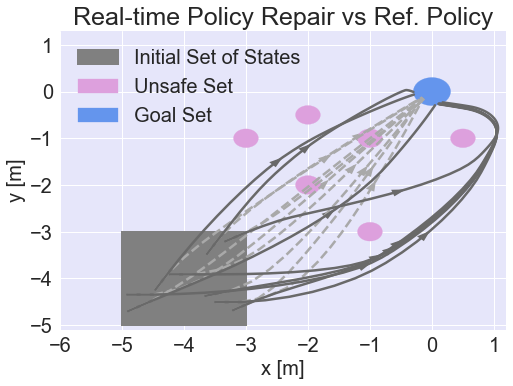

In [365]:
left, bottom, width, height = (x0_interval[0][0], x0_interval[1][0], 2, 2)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=True,
                        color="grey",
                       linewidth=2, label = "Initial Set of States")
                       #facecolor="red")
for traj in trajectory_ref:
    plt.plot(np.array(traj)[:,0],np.array(traj)[:,1], linestyle ="--", linewidth=2.5, color= 'darkgray')
    plt.arrow(np.array(traj)[10,0], np.array(traj)[10,1], np.array(traj)[11,0]-np.array(traj)[10,0], np.array(traj)[11,1]-np.array(traj)[10,1], shape='full', color= 'darkgray', lw=0, length_includes_head=True, head_width=0.15)


for traj in trajectory:
    plt.plot(np.array(traj)[:,0],np.array(traj)[:,1], linewidth=2.5, color= 'dimgray')
    plt.arrow(np.array(traj)[10,0], np.array(traj)[10,1], np.array(traj)[11,0]-np.array(traj)[10,0], np.array(traj)[11,1]-np.array(traj)[10,1], shape='full', color= 'dimgray', lw=0, length_includes_head=True, head_width=0.15)

plt.xlabel('x [m]',fontsize=20)
plt.ylabel('y [m]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((-6,1.2))
plt.ylim((-5.1,1.3))
plt.title(r'Real-time Policy Repair vs Ref. Policy',fontsize=25)
ax = plt.gca()
ax.add_patch(rect)
ax.set_facecolor("lavender")
for k in range(xo.shape[0]-1):
    ax.add_patch(plt.Circle((xo[k, 0], xo[k, 1]), xo[k, 2], color='plum', fill=True))
ax.add_patch(plt.Circle((xo[-1, 0], xo[-1, 1]), xo[-1, 2], color='plum', fill=True, label="Unsafe Set")) 
ax.add_patch(plt.Circle((xg[0], xg[1]), xg[2], color='cornflowerblue', fill=True, label="Goal Set"))
#ax.add_patch(plt.Circle((xo[0], xo[1]), xo[2], color='plum', fill=True, label="Unsafe Set"))
# ax.quiver(np.concatenate(traj_rep1)[:,0],np.concatenate(traj_rep1)[:,1],np.concatenate(traj_rep_dot1)[:,0],np.concatenate(traj_rep_dot1)[:,1],color = "darkgray")
ax.legend(loc="upper left",fontsize=20,frameon=False)
plt.savefig('real_time_multi_traj.eps', format='eps')

In [255]:
# model_orig.save('model_3_out/my_model')

In [95]:
#model_orig.save_weights('saved_model10/weights')

In [711]:
#temp = keras.models.load_model('saved_model10/my_model', compile=False)

In [712]:
#model_orig = keras.models.load_model('saved_model6/my_model')